In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Low_Rank_Approximation.approximate_multiplication import approx_SVD
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import pairwise

In [69]:
df = pd.read_csv("Data/blogfeedback/blogData_train.csv", header=None)
# Shuffle
test = round(.7 * df.shape[0])
y = df.iloc[:,280]
X = df.iloc[:,:280]
y_train = df.iloc[:test,280]
X_train = df.iloc[:test,:280]
y_test = df.iloc[test:,280]
X_test = df.iloc[test:, :280]

scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


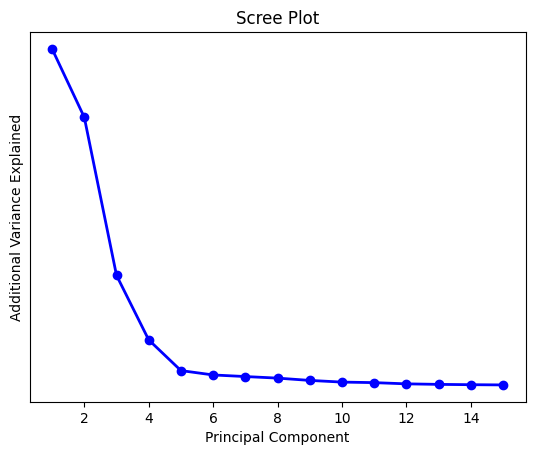

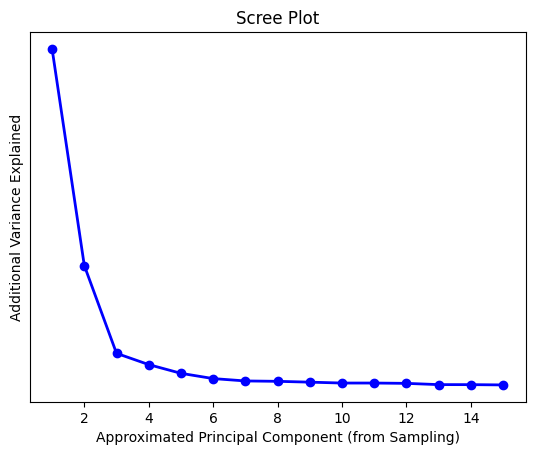

In [43]:
pca = PCA(n_components=15)
pca_fit = pca.fit(X_scaled)
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Additional Variance Explained')
# Remove ticks on y axis
plt.yticks([])
plt.show()

V = approx_SVD(X_scaled.to_numpy(), 400)
projection = np.zeros((280, 280))
sum_variances = []
for i in range(len(V)):
    projection += np.outer(V[i], V[i])
    sum_variances.append(np.linalg.norm(X_scaled @ projection))

variances = [sum_variances[0]] + [y - x for x, y in pairwise(sum_variances)]
variances.sort(reverse=True)

variances /= np.linalg.norm(X_scaled)
plt.plot(PC_values, variances[:pca.n_components_], 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Approximated Principal Component (from Sampling)')
plt.ylabel('Additional Variance Explained')
plt.yticks([])
plt.show()

In [64]:
import numpy as np
import numba
import time
import scipy

# Helper functions for Least Squares Approximation: Random Projection and Sketching
@numba.jit(nopython=True)
def hamming_weight_array(x):
    count_array = np.zeros_like(x, dtype=np.int8)
    for index in np.ndindex(x.shape):
        count = 0
        value = x[index]
        while value:
            count += value & 1
            value >>= 1
        count_array[index] = count
    return count_array


@numba.jit(nopython=True)
def vectorized_hadamard_rows_with_D(row_indices, n):
    output_rows = np.empty((len(row_indices), n), dtype=np.int8)
    # D = 2 * np.random.randint(0, 2, size=n) - 1
    indices_j = np.arange(n)
    # Compute the Hadamard matrix rows for the given indices
    for count, i in enumerate(row_indices):
        # Compute bitwise AND for every pair i and all j indices
        binary_dot_products = np.bitwise_and(i, indices_j)
        # Compute the Hadamard matrix row entries, then multiply -1 with 0.5 probability
        output_rows[count] = hamming_weight_array(binary_dot_products) * (2 * np.random.randint(0, 2, size=1) - 1)
    return (-1) ** output_rows


# Helper functions for Least Squares Approximation: Random Sampling
def generate_random_projection(r_1, r_2):
    # Generates the randomized unstructured projection (P in our paper)
    return np.random.choice([-np.sqrt(3/r_1), np.sqrt(3/r_1), 0], size=(r_1, r_2), p=[1/6, 1/6, 2/3])


@numba.jit(nopython=True)
def sample_indices(row_indices, n):
    sampled_indices = np.zeros(n, dtype=np.int8)
    for i in range(n):
        random_value = np.random.random()
        cum_sum = 0.0
        for j, weight in enumerate(row_indices):
            cum_sum += weight
            if random_value < cum_sum:
                sampled_indices[i] = j
                break 
    return sampled_indices


def sketch_and_solve(A, b, r, direct=True, precondition_with_QR=False, **kwargs):
    """
    Parameters:
        A: matrix of size m x n
        b: vector of size m (we want to solve Ax = b)
        r: sketch size (dimension we are projecting to)
        direct: whether to use a direct solver or an iterative solver to solve the least squares problem
        precondition_with_QR: whether to precondition the least squares problem with the sketch matrix (for MINRES)
    
    Returns:
        solution to the least squares problem
    """
    m = A.shape[0]
    rand_rows = np.random.choice(m, r, replace=True)
    SH_mD = vectorized_hadamard_rows_with_D(rand_rows, m)
    # Multiply the rows by the Hadamard matrix
    if direct:
        return scipy.linalg.lstsq(SH_mD @ A, SH_mD @ b)[0]
    else:
        if precondition_with_QR:
            _, R = np.linalg.qr(SH_mD @ A)
            minres_sol = scipy.sparse.linalg.minres((SH_mD @ A).T @ (SH_mD @ A) @ R, (SH_mD @ A).T @ SH_mD @ b, **kwargs)[0]
            return np.linalg.solve(R, minres_sol)
        return scipy.sparse.linalg.minres((SH_mD @ A).T @ (SH_mD @ A), (SH_mD @ A).T @ SH_mD @ b, **kwargs)[0]


def sample_and_solve(A, b, r_1, r_2, k, direct=True, precondition_with_QR=False, **kwargs):
    """
    Parameters:
        A: matrix of size m x n
        b: vector of size m (we want to solve Ax = b)
        r_1: sketch size
        r_2: sketch size
        k: number of samples to take for our sketch
        direct: whether to use a direct solver or an iterative solver to solve the least squares problem
        precondition_with_QR: whether to precondition the least squares problem with the sketch matrix (for MINRES)
    
    Returns:
        solution to the least squares problem
    """
    m = A.shape[0]
    rand_rows = np.random.choice(m, r_1, replace=True)
    P = generate_random_projection(r_1, r_2)
    SH_mD = vectorized_hadamard_rows_with_D(rand_rows, m)
    approximate_lev = np.sum((A @ np.linalg.pinv(SH_mD @ A) @ P) ** 2, axis=1)
    approximate_lev /= np.sum(approximate_lev)
    sampled_indices = sample_indices(approximate_lev, k)
    approximate_lev *= k
    sampled_sketch_A = A[sampled_indices] * approximate_lev[sampled_indices, None]
    sampled_sketch_b = b[sampled_indices] * approximate_lev[sampled_indices]
    if direct:
        return scipy.linalg.lstsq(sampled_sketch_A, sampled_sketch_b)[0]
    else:
        if precondition_with_QR:
            _, R = np.linalg.qr(sampled_sketch_A)
            minres_sol = scipy.sparse.linalg.minres(sampled_sketch_A.T @ sampled_sketch_A @ R, sampled_sketch_A.T @ sampled_sketch_b, **kwargs)[0]
            return np.linalg.solve(R, minres_sol)
        return scipy.sparse.linalg.minres(sampled_sketch_A.T @ sampled_sketch_A, sampled_sketch_A.T @ sampled_sketch_b, **kwargs)[0]

In [66]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

pca = PCA(n_components=8)
X_train_scaled = scaler.fit_transform(X_train)
pca_fit = pca.fit(X_train_scaled)
X_train_pca = pca_fit.transform(np.array(X_train_scaled))

beta1 = sketch_and_solve(np.array(X_train_pca), np.array(y_train), 1000)
print(r2_score(y_train, X_train_pca @ beta1))
beta2 = np.linalg.lstsq(X_train, y_train)[0]
print(r2_score(y_train, X_train @ beta2))
# beta3 = Ridge(alpha=0.25).fit(X_train, y_train).coef_

pred1 = pca_fit.transform(scaler.transform(X_test)) @ beta1
pred2 = X_test @ beta2
# pred3 = X_test @ beta3

print(r2_score(y_test, pred1))
print(mean_squared_error(y_test, pred1))
print(r2_score(y_test, pred2))
print(mean_squared_error(y_test, pred2))
# print(mean_squared_error(y_test, pred3))

0.23872320281805415


/var/folders/3y/gbytrhp16tx3vv7jb3f_g_sm0000gn/T/ipykernel_99306/4096409857.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta2 = np.linalg.lstsq(X_train, y_train)[0]


0.38616620607840024
-0.6684762953491497
708.0034779653662
-341070317.4129198
144730238206.09308


In [64]:
np.sum(y_test == 0)

8165

In [54]:
beta1 = sketch_and_solve(np.array(X_pca), np.array(y), 1000)

In [47]:
beta2 = np.linalg.lstsq(X, y)[0]

/var/folders/m3/pz21nfxs75xgf_18thskgtw40000gn/T/ipykernel_95570/765610259.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta2 = np.linalg.lstsq(X, y)[0]


In [55]:
from sklearn.metrics import r2_score

r2_score(y, X_pca @ beta1)

NameError: name 'X_pca' is not defined

In [49]:
from sklearn.metrics import r2_score

r2_score(y, X @ beta2)

0.36475879203673145